In [2]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS, to_rgb
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
import warnings
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, ttest_ind, ttest_1samp, wilcoxon, sem
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle, put_text
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.strikes.strikes import Loader, StrikeAnalyzer
from analysis.predictors.trajectories import TrajClassifier, TRAJ_DIR
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.direction"] = 'out'

/home/regev/anaconda3/envs/PreyTouch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
ANIMALS = ['PV91', 'PV163', 'PV95', 'PV99']
MOVEMENTS_TYPES = ['random_low_horizontal', 'circle']
orm = ORM()

def load_trajs_dataset():
    with orm.session() as s:
        orm_res = s.query(Strike, Trial, Block, Experiment).join(
            Trial, Trial.id == Strike.trial_id).join(
            Block, Block.id == Strike.block_id).join(
            Experiment, Experiment.id == Block.experiment_id).filter(
                Experiment.arena.in_(['reptilearn4']),
                Experiment.animal_id.in_(ANIMALS),
                Experiment.start_time > '2023-04-18',
                Block.movement_type.in_(MOVEMENTS_TYPES)
          ).all()
        
    strk_df_ = []
    trajs_ = {}
    for strk, tr, blk, exp in orm_res:
        if tr.bug_trajectory is None:
           continue
        
        try:
            strike_id = int(strk.id)
            ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=True, sec_before=3, sec_after=3)
            pose_df = ld.frames_df.copy()
            pose_df['total_sec'] = (pose_df[('time', '')] - pose_df.loc[ld.strike_frame_id, ('time', '')]).dt.total_seconds()
            pose_df = pd.concat([pose_df['time'], pose_df['total_sec'], pose_df['nose'][['x', 'y', 'prob']], pose_df['angle']], axis=1)
            pose_df['strike_id'] = strike_id
            trajs_[strike_id] = pose_df
            
            strk_df_.append({'id': strike_id, 'animal_id': exp.animal_id, 'block_id': blk.id, 'trial_id': tr.id, 'movement_type': blk.movement_type,
                             'time': strk.time, 'block_speed': blk.bug_speed, 'calc_speed': strk.calc_speed, 'is_hit': strk.is_hit, 'bug_type': strk.bug_type})
        except Exception as exc:
            print(f'Error in strike id: {strike_id}; {exc}')
            continue
      
    strk_df_ = pd.DataFrame(strk_df_).set_index('id')
    # add the frame_strike_id column to indicate which strike_id corresponds to each frame
    for strike_id, tf in trajs_.items():
        tf['frame_strike_id'] = None
        trial_id = strk_df_.loc[strike_id, 'trial_id']
        for strike_id_, row in strk_df_.query(f'trial_id=={trial_id}').iterrows():
            if tf.time.iloc[0] <= row.time <= tf.time.iloc[-1]:
                i = (tf.time - row.time).dt.total_seconds().abs().idxmin()
                tf.loc[i, 'frame_strike_id'] = strike_id_
    
    return strk_df_, trajs_


strk_df, trajs = load_trajs_dataset()

Error in strike id: 2583; Video prediction was not found for video db id: 2573
Error in strike id: 2584; Video prediction was not found for video db id: 2573
Error in strike id: 2585; Video prediction was not found for video db id: 2573
Error in strike id: 2586; Video prediction was not found for video db id: 2573
Error in strike id: 2587; Video prediction was not found for video db id: 2573
Error in strike id: 2582; Video prediction was not found for video db id: 2573
Error in strike id: 2624; Video prediction was not found for video db id: 2602
Error in strike id: 2625; Video prediction was not found for video db id: 2602
Error in strike id: 2627; Video prediction was not found for video db id: 2602
Error in strike id: 2626; Video prediction was not found for video db id: 2602
Error in strike id: 2630; Video prediction was not found for video db id: 2619
Error in strike id: 2631; Video prediction was not found for video db id: 2619
Error in strike id: 2581; Video prediction was not f

In [58]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'wb') as f:
    pickle.dump({'strk_df': strk_df, 'trajs': trajs}, f)

### All animals, Circle

Resampling trajectories to 65 samples from each block_speed class
Traj classes count: {2: 65, 4: 65, 6: 65, 8: 65}
Start train for model traj_classifier_all_circle. Train will be running on cuda:0 device


FOLD-#5  val_loss=1.95 (best=1.32): 100%|██████████| 150/150 [01:04<00:00,  2.32it/s]


Chosen model is of Fold#4
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_all_circle/20240714_181616
Resampling trajectories to 65 samples from each block_speed class
Traj classes count: {2: 65, 4: 65, 6: 65, 8: 65}


100%|██████████| 260/260 [00:00<00:00, 343.33it/s]


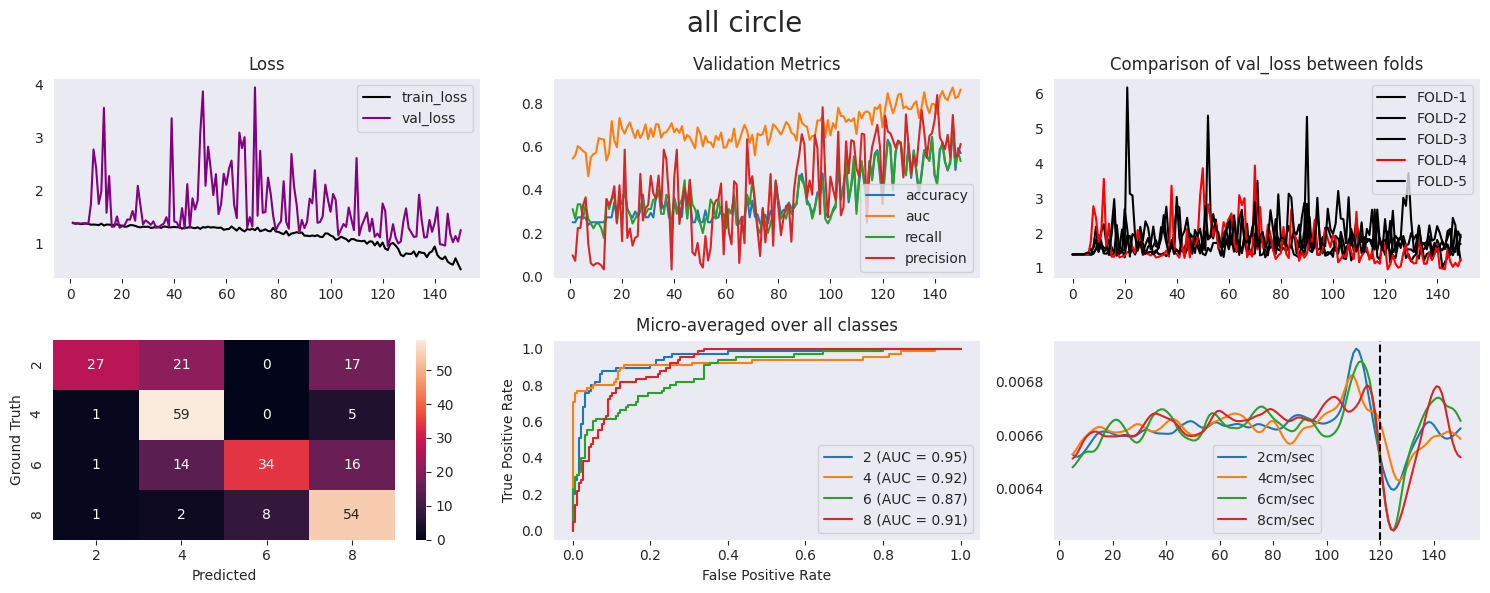

In [14]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=True,
                    animal_id='all', movement_type='circle', is_hit=False, lstm_layers=6, dropout_prob=0.5)
tj.train(is_plot=True);

### All animals, random_low_horizontal

Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}
Start train for model traj_classifier_all_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5  val_loss=1.68 (best=1.13): 100%|██████████| 150/150 [01:06<00:00,  2.24it/s]


Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240716_134800
Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}


100%|██████████| 449/449 [00:00<00:00, 558.87it/s]


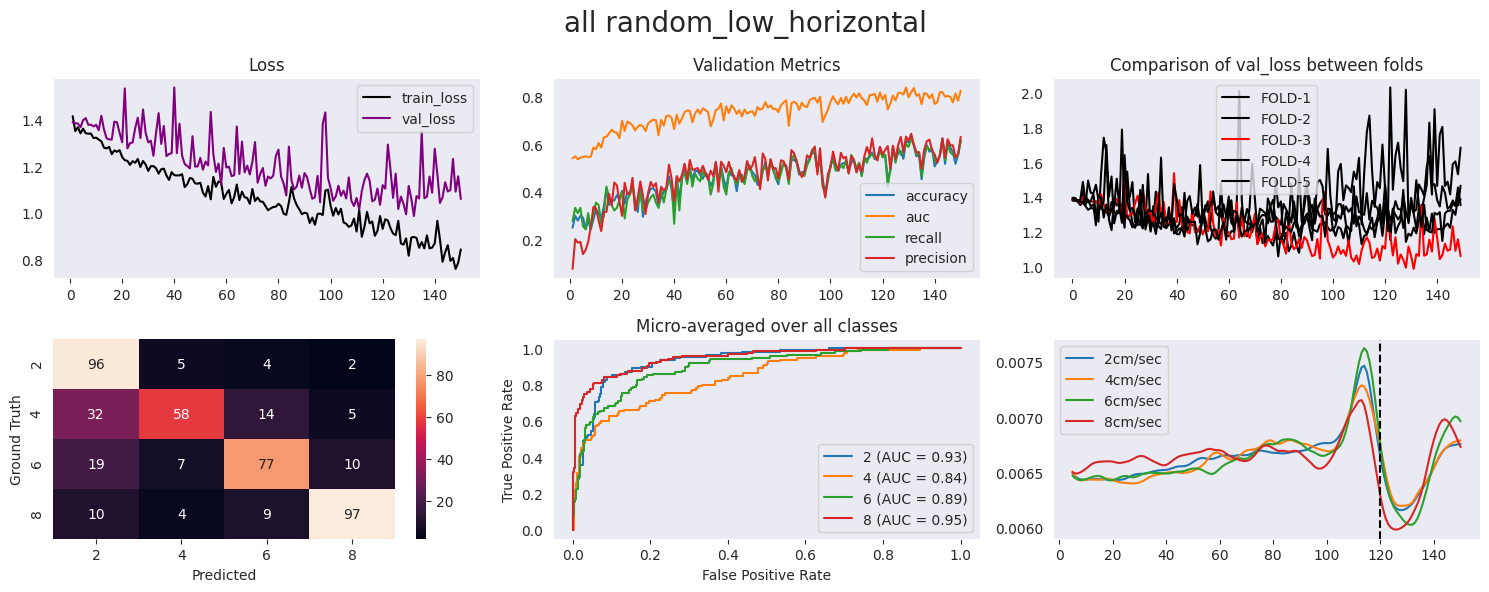

In [25]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
tj.train(is_plot=True);

### PV91, random_low_horizontal

Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}
Start train for model traj_classifier_PV91_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5  val_loss=1.51 (best=0.87): 100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240716_135551
Traj classes count: {2: 31, 4: 34, 6: 32, 8: 30}


100%|██████████| 127/127 [00:00<00:00, 575.92it/s]


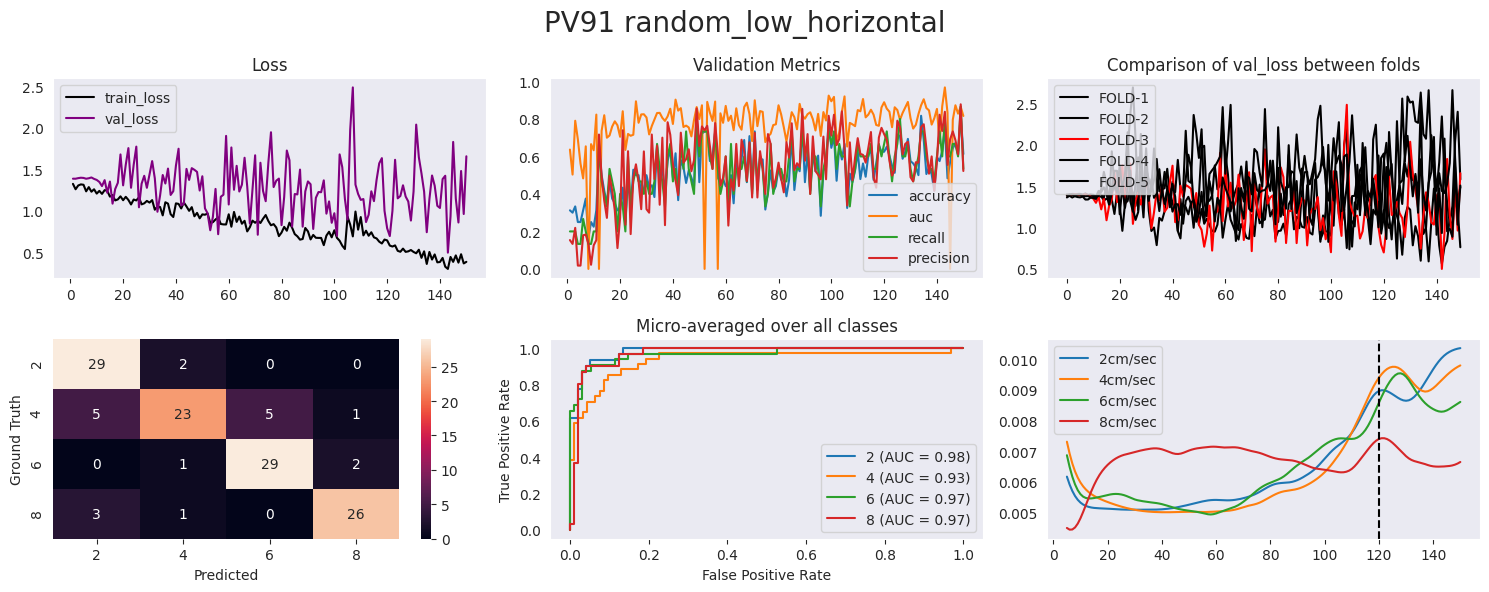

In [26]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
                    animal_id='PV91', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,)
tj.train(is_plot=True);

### Target = is_hit

Traj classes count: {0: 202, 1: 247}
Start train for model traj_classifier_all_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5  val_loss=0.58 (best=0.44): 100%|██████████| 150/150 [01:06<00:00,  2.24it/s]


Chosen model is of Fold#2
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240716_181349
Traj classes count: {0: 202, 1: 247}


100%|██████████| 449/449 [00:00<00:00, 556.40it/s]


IndexError: index 1 is out of bounds for axis 1 with size 1

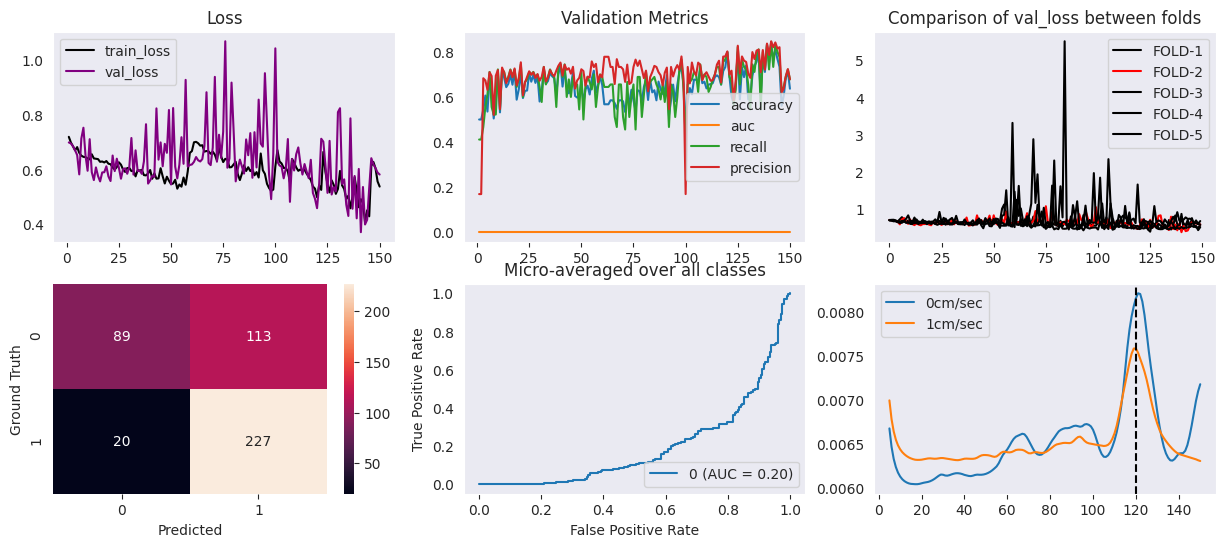

In [42]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,
                    target_name='is_hit', targets=[0, 1])
tj.train(is_plot=True);

### Target = bug type

worm            155
cockroach       106
red_beetle       74
green_beetle     54
Name: bug_type, dtype: int64
Resampling trajectories to 54 samples from each bug_type class
Traj classes count: {'worm': 54, 'cockroach': 54, 'red_beetle': 54, 'green_beetle': 54}
Start train for model traj_classifier_all_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#5  val_loss=2.05 (best=1.08): 100%|██████████| 150/150 [01:01<00:00,  2.44it/s]


Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240718_140341
worm            155
cockroach       106
red_beetle       74
green_beetle     54
Name: bug_type, dtype: int64
Resampling trajectories to 54 samples from each bug_type class
Traj classes count: {'worm': 54, 'cockroach': 54, 'red_beetle': 54, 'green_beetle': 54}


100%|██████████| 216/216 [00:00<00:00, 575.60it/s]


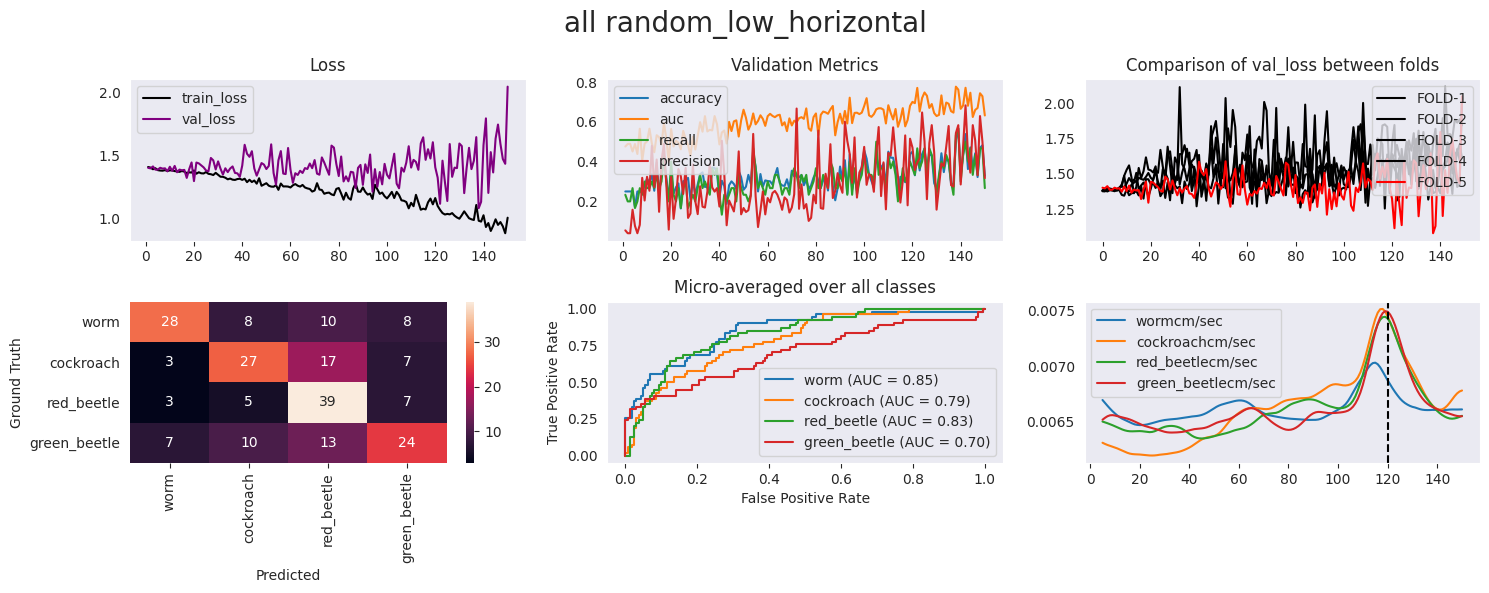

In [73]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=True,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,
                    target_name='bug_type', targets=['worm', 'cockroach', 'red_beetle', 'green_beetle'])
tj.train(is_plot=True);

### Find best set of features

In [ ]:
import itertools

l = ['x', 'y', 'prob', 'speed', 'angle']
res_df = []
for L in range(1, len(l) + 1):
    for feature_names in itertools.combinations(l, L):
        print(f'Start training with features {feature_names}')
        try:
            tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False, 
                                feature_names=feature_names, animal_id='all', movement_type='random_low_horizontal', is_hit=False, 
                                lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
            tj.train(is_plot=False)
            best_i = np.argmin([x['score'] for x in tj.history])
            best_epoch = np.argmin(tj.history[best_i]['metrics']['val_loss'])
            for metric, l in tj.history[best_i]['metrics'].items():
                res_df.append({'features': feature_names, 'metric': metric, 'value': l[best_epoch]})
        except Exception as exc:
            print(f'Error in feature names: {feature_names}; {exc}')
    res_df = pd.DataFrame(res_df)
    filename = f'{TRAJ_DIR}/features_results_{datetime.now().isoformat()}.csv'
    res_df.to_csv(filename)  
res_df

Start training with features ('x',)
Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}
Start train for model traj_classifier_all_random_low_horizontal. Train will be running on cuda:0 device


FOLD-#1  val_loss=1.34 (best=1.36):  16%|█▌        | 24/150 [00:10<00:56,  2.24it/s]

In [96]:
res_df

,features,metric,value
0,"(x,)",train_loss,1.275316
1,"(x,)",val_loss,1.262133
2,"(x,)",accuracy,0.373851
3,"(x,)",auc,0.637466
4,"(x,)",recall,0.366667
5,"(x,)",precision,0.501430
6,"(y,)",train_loss,1.274599
7,"(y,)",val_loss,1.251186
8,"(y,)",accuracy,0.411769
9,"(y,)",auc,0.695548


In [ ]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240714_123934')
tj.all_data_evaluation()

In [ ]:
res = []
for sub_sect in [(-3, 180), (-2.5, 150), (-2, 120), (-1.5, 90), (-1, 60), (-0.5, 30), (-0.2, 12), (-0.1, 6)]:
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=sub_sect, is_resample=False,
                            animal_id='PV91', movement_type='random_low_horizontal', is_single_strike=False)
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['sub_section'] = sub_sect
        res.append(d)
    except Exception as exc:
        print(f'{sub_sect}: {exc}')

res = pd.DataFrame(res).set_index('sub_section')
res.plot()

In [60]:
np.arange(-3, 2.5, 0.5)

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

In [ ]:
movement_type = 'random_low_horizontal'
for animal_id in ['PV91', 'PV163']:
    res = []
    for start_time in np.arange(-3, 2.5, 0.25):
        try:
            tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(start_time, 60), is_resample=False,
                                animal_id=animal_id, movement_type=movement_type, is_hit=False)
            tj.train(is_plot=False)
            d = tj.calc_auc()
            d['start_time'] = start_time + 0.5
            res.append(d)
        except Exception as exc:
            print(f'{exc}')

    res = pd.DataFrame(res).set_index('start_time')
    plt.figure()
    res.plot()
    plt.title(f'Animal ID: {animal_id}, Movement Type: {movement_type}')
    plt.ylabel('AUC')

In [33]:
res.mean(axis=1).idxmax()

(-2.5, 150)

In [66]:
res = {}
for strike_id, row in strk_df.iterrows():
    res.setdefault(row.animal_id, 0)
    if len(trajs[strike_id].frame_strike_id.value_counts()) == 1:
        res[row.animal_id] += 1

for animal_id, c in res.items():
    total = len(strk_df.query(f'animal_id=="{animal_id}"'))
    print(f'{animal_id}: {c}/{total}')

PV91: 184/369
PV99: 153/202
PV163: 122/186


In [52]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
    d_ = pickle.load(f)
    strk_df, trajs = d_['strk_df'], d_['trajs']

In [54]:
strk_df.bug_type.value_counts()

worm            262
cockroach       189
green_beetle    151
red_beetle      149
ant              66
spider           63
Name: bug_type, dtype: int64

<AxesSubplot:xlabel='t0'>

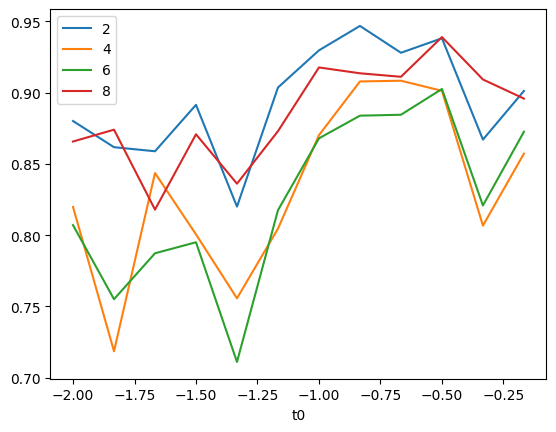

In [20]:
pd.DataFrame(res).set_index('t0').plot()

In [11]:
trajs[103]

,time,total_sec,x,y,prob,angle,strike_id,frame_strike_id
1876,2023-05-13 17:30:58.430510080,-2.999953,86.673642,59.457081,0.000014,2.378555,103,None
1877,2023-05-13 17:30:58.447176960,-2.983286,86.661825,59.449744,0.000014,2.382324,103,None
1878,2023-05-13 17:30:58.463843072,-2.966620,86.668932,59.451321,0.000015,2.376944,103,None
1879,2023-05-13 17:30:58.480508928,-2.949954,86.671703,59.451836,0.000014,2.378139,103,None
1880,2023-05-13 17:30:58.497175808,-2.933287,86.662005,59.448859,0.000014,2.381802,103,None
...,...,...,...,...,...,...,...,...
2172,2023-05-13 17:31:03.363766016,1.933303,38.375601,-2.057227,0.999967,1.593862,103,None
2173,2023-05-13 17:31:03.380433152,1.949970,38.420876,-1.589263,0.999987,1.598387,103,None
2174,2023-05-13 17:31:03.397099008,1.966636,38.439968,-1.247421,0.999963,1.603667,103,None
2175,2023-05-13 17:31:03.413764864,1.983302,38.397328,-0.991973,0.999987,1.611177,103,None


In [16]:
row = strk_df.iloc[0]
row.time

Timestamp('2023-05-16 18:34:46.391000')

In [ ]:
res2 = []
for t0 in (np.arange(-5, 60, 10) / 60):
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(t0, 60),
                        animal_id='PV91', movement_type='random_low_horizontal')
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['t0'] = t0
        res2.append(d)
    except Exception as exc:
        print(f'Error in t0: {t0}; {exc}')
        continue
    
res2 = pd.DataFrame(res2)
res2

<AxesSubplot:xlabel='t0'>

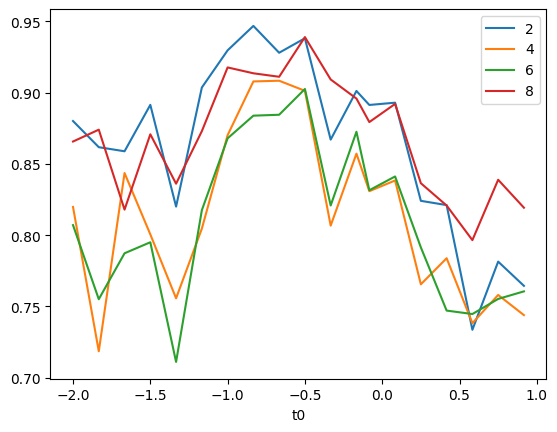

In [32]:
pd.concat([pd.DataFrame(res), res2]).set_index('t0').sort_index().plot()

In [49]:
eval_df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-07-16T21:30:01.178974.csv', index_col=0)
# eval_df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-07-15T19:54:59.448642.csv', index_col=0)

In [50]:
eval_df.query('metric=="val_loss"').sort_values(by='value')

,metric,value,animal_id,movement_type,dropout_prob,lstm_hidden_dim,lstm_layers
79,val_loss,0.855128,all,circle,0.3,100,6
97,val_loss,0.875062,all,circle,0.3,150,6
25,val_loss,0.949072,all,circle,0.1,100,6
1,val_loss,0.957532,all,circle,0.1,50,4
127,val_loss,0.978889,all,circle,0.4,100,4
19,val_loss,0.985365,all,circle,0.1,100,4
181,val_loss,0.988547,all,circle,0.6,100,4
109,val_loss,0.991497,all,circle,0.4,50,4
43,val_loss,1.005792,all,circle,0.1,150,6
169,val_loss,1.018830,all,circle,0.6,50,6


In [51]:
eval_df.query('metric=="accuracy"').sort_values(by='value', ascending=False)

,metric,value,animal_id,movement_type,dropout_prob,lstm_hidden_dim,lstm_layers
80,accuracy,0.658586,all,circle,0.3,100,6
134,accuracy,0.656791,all,circle,0.4,100,6
98,accuracy,0.625000,all,circle,0.3,150,6
26,accuracy,0.611264,all,circle,0.1,100,6
128,accuracy,0.605195,all,circle,0.4,100,4
170,accuracy,0.599405,all,circle,0.6,50,6
56,accuracy,0.588131,all,circle,0.3,50,4
2,accuracy,0.575107,all,circle,0.1,50,4
200,accuracy,0.559524,all,circle,0.6,150,4
116,accuracy,0.556548,all,circle,0.4,50,6


array(['train_loss', 'val_loss', 'accuracy', 'auc', 'recall', 'precision'],
      dtype=object)